# Visualizing PerceptionLM on Perception Test with TransformerLens

In this notebook, you will see simple example of how to use TransformerLens for PerceptionLM interpretability. More specifically you can pass united image patch embeddings and textual embedding to the language backbone (LLama 3) with TransformerLens and get logits and cache that contains activations for next analysis. While we only use the attention maps, with the full power of TransformerLens you should have many more options for analysis to do. This was modified from the original LLaVA demo notebook.

Here we consider just four frames for simplicity to keep memory costs low, but it is an interesting interpretability challenge to investigate higher frame counts.

Make sure to clone the following repo and install before running this notebook, which provides functionality for using PerceptionLM. You can do so as follows. First create an environment and install the base libraries.

```bash
conda create -n plm_lens python=3.12
conda activate plm_lens


git clone git@github.com:ptchallenge-workshop/TransformerLens.git
cd TransformerLens
pip install -e .
pip install jupyter ipynotebook circuitsvis opencv-python pillow matplotlib timm mediapy

# for ffmpeg, and torchcodec compatibility, as torchcodec is soon to be the new default video backend
conda install "ffmpeg<8" -c conda-forge 

# can be finicky, look at installation if having trouble.
pip install torchcodec 
```

In [1]:
import os
import zipfile
import numpy as np 
import cv2
import colorsys
import json
import random
from typing import Tuple, List, Dict
import mediapy
import requests

import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from huggingface_hub import hf_hub_download

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
%matplotlib inline

from transformer_lens import HookedTransformer
import circuitsvis as cv

_ = torch.set_grad_enabled(False)

## Simple HookedTransformer Demo on images

### Prepare Model

Load PLM from hugging face with their demo image from huggingface. In float16, PLM-8B requires 20GB of GPU memory to load and 55GB to run one-step generation on 4 frames, whereas PLM-1B requires 2.5GB to load. Sharding across devices is not implemented yet.

In [2]:
# model_id, llm_id = "facebook/Perception-LM-1B", "meta-llama/Llama-3.2-1B-Instruct"
model_id, llm_id = "facebook/Perception-LM-8B", "meta-llama/Llama-3.1-8B-Instruct"

model = AutoModelForImageTextToText.from_pretrained(
	model_id, 
	dtype=torch.float16,
	device_map="cuda" # TODO: Debug how to fix auto mapping
)

for param in model.parameters():  # At this demo we don't need grads
	param.requires_grad = False

processor = AutoProcessor.from_pretrained(model_id)
processor.image_processor.vision_input_type = "vanilla"
tokenizer = processor.tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# Taking model apart
language_model = model.model.language_model.eval()

To support PLM, we can pass it into `HookedTransformer` as an instance of a LLama-3.1/3.2 model. We need to do some minor remapping to accommodate this, so we added a `plm` flag which indicates when this needs to happen.

In [4]:
language_model.lm_head = model.lm_head # needed since the mapping of PLM is slightly different, saves on passing PE weights
text_cfg = model.config.text_config

# Manually override relevant config parameters
hooked_model = HookedTransformer.from_pretrained(
	llm_id,  # Use config of llama
	hf_model=language_model,
	# device_map="auto",
	dtype="float16",
	plm=True, # need to load the model slightly differently
	bos_token_id=text_cfg.bos_token_id,
	eos_token_id=text_cfg.eos_token_id,
	head_dim=text_cfg.head_dim,
	intermediate_size=text_cfg.intermediate_size,
	max_position_embeddings=text_cfg.max_position_embeddings,
	num_key_value_heads=text_cfg.num_key_value_heads,
	rope_theta=text_cfg.rope_theta,
	vocab_size=text_cfg.vocab_size	
)

Loaded pretrained model meta-llama/Llama-3.1-8B-Instruct into HookedTransformer


In [5]:
hooked_model.cfg.n_ctx = text_cfg.max_position_embeddings

Because of our patch above, we need to separate the image processing from the LLM processing, as `transformerlens` has no idea how to handle the image inputs. 

In [6]:
def get_llm_input_image_embeddings(model, processor, image: str, text: str, device='cuda'):
    """ Extract features from image, project them to LLM's space and insert them to text embedding sequence.  
    Returns: 
    	inputs_embeds, attention_mask, position_ids - input for language model of PLM
    """
    conversation = [
      {
        "role": "user",
        "content": [
            {"type": "image", "url": image},
            {"type": "text", "text": text},
          ],
      },
    ]
    inputs = processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True,
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt", 
        images_kwargs={
          "vision_input_type": "vanilla",
          "tile_size": 448,
          "max_num_tiles": 1,
        }
    )
    inputs = inputs.to(device, torch.float16)
    
    model.eval()
    
    inputs_embeds = model.get_input_embeddings()(inputs['input_ids'])
    
    if "pixel_values" in inputs: 
        # print(f"{model.model.vision_tower.device=}, {inputs['pixel_values'].device=}")
        pixel_values = inputs['pixel_values'].to(model.model.vision_tower.device)
        image_features = model.model.get_image_features(pixel_values=pixel_values)
        image_features = image_features.to(inputs_embeds.device, dtype=inputs_embeds.dtype)
        special_image_mask, _ = model.model.get_placeholder_mask(
            inputs['input_ids'], inputs_embeds=inputs_embeds, image_features=image_features
        )
        inputs_embeds = inputs_embeds.masked_scatter(special_image_mask, image_features)

    return inputs_embeds, inputs['attention_mask'], inputs

In [7]:
test_image_file = hf_hub_download(
    repo_id="shumingh/perception_lm_test_images",
    filename="14496_0.PNG",
    repo_type="dataset",
)

In [8]:
question = "Describe what you see in the picture in detail."
inputs_embeds, attn_mask, inputs = get_llm_input_image_embeddings(model, processor, test_image_file, question, device=device)

# Return tokens 
outputs = hooked_model.generate(
    inputs_embeds,
    max_new_tokens=400,
	do_sample=True,
    return_type='tokens'
)
generated_text = processor.decode(outputs[0], skip_special_tokens=True)
print('Generated text:', generated_text)

  0%|          | 0/400 [00:00<?, ?it/s]

Generated text: The image features four blue bars of varying heights on an eggshell blue background. There is no text displayed. 

There is a vertical axis labeled "Values" in darker blue. Horizontal columns extend to the right imprinted with different keys: step, horror, mood, and lumber. The y-axis scale measures values on a numerical scale of 0-10 as increments of 2. 

The first bar located at the bottom "#step" is imprinted with vertical blue lines as the bars gradually decrease in size, leaving the largest bar at the top. maliciousSec clearance area Tar Heels strength. The bars decrease in value as they move from the left, "Horror" is imprinted with clue text and a yellow star, followed closely by "Mood." Then the last bar, "Lumber" stands out.22. The background features a grid, rater notes without atr.


In [9]:
# Now return embeddings and then project them on vocab space
outputs = hooked_model.generate(
	inputs_embeds,
	max_new_tokens=30,
	do_sample=True,
)

logits = outputs[:,-30:,:].to(device) @ language_model.embed_tokens.weight.T.to(device)
generated_text = processor.decode(logits.argmax(-1)[0], skip_special_tokens=True)
print('Generated text:', generated_text)

  0%|          | 0/30 [00:00<?, ?it/s]

Generated text: This image displays a bar graph with four bars, labeled step, horror, mood and lumber. The Y axis is labeled 'Values', while the x


As we can see everything is working. Now try visualize attention patterns in generated output. We use a simple helper function to extract out the last multimodal index.

In [10]:
def find_last_multimodal_index(input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Finds the index of the last occurrence of 128002 or 128003 in an input tensor.

    If the input is 2D (batch_size, sequence_length), it returns a 1D tensor of
    indices for each row.
    If the input is 1D (sequence_length), it returns a scalar tensor with the index.

    If neither token is found in a row (or in the 1D tensor), -1 is returned for that row.

    Args:
        input_tensor: A 1D or 2D tensor of token IDs.

    Returns:
        A tensor containing the last indices.
    """
    if input_tensor.dim() not in [1, 2]:
        raise ValueError("Input tensor must be 1D or 2D.")

    was_1d = input_tensor.dim() == 1
    if was_1d:
        input_tensor = input_tensor.unsqueeze(0)

    # Create a boolean mask where the elements are True if they match the special tokens
    mask = (input_tensor == 128002) | (input_tensor == 128003)

    # Create a tensor of indices, e.g., [0, 1, 2, ..., seq_len-1]
    seq_len = input_tensor.shape[1]
    indices = torch.arange(seq_len, device=input_tensor.device)

    # Broadcast the indices and use the mask to select them.
    # Where the mask is False, we use -1 as a placeholder.
    masked_indices = torch.where(mask, indices, -1)

    # The last occurrence corresponds to the maximum index in each row.
    # If no token is found in a row, the max will be -1.
    last_occurrence_indices = torch.max(masked_indices, dim=1).values

    if was_1d:
        return last_occurrence_indices.squeeze(0)
        
    return last_occurrence_indices

In [11]:
find_last_multimodal_index(inputs['input_ids'])[0].item()

300

In [12]:
# Here we visualize attention for the last 30 tokens. 
logits, cache = hooked_model.run_with_cache(inputs_embeds, start_at_layer=0, remove_batch_dim=True)

layer_to_visualize = 16
# tokens_to_show = 30
start_index = find_last_multimodal_index(inputs['input_ids'])[0].item() + 1
attention_pattern = cache["pattern", layer_to_visualize - 1, "attn"]

product = inputs_embeds @ language_model.embed_tokens.weight.T.to(device)  # Project embeddings to vocab
llama_str_tokens = hooked_model.to_str_tokens(product.argmax(dim=-1)[0])

print(f"Layer {layer_to_visualize} Head Attention Patterns:")
display(cv.attention.attention_patterns(tokens=llama_str_tokens[start_index:], 
										attention=attention_pattern[:, start_index:, start_index:]))

Layer 16 Head Attention Patterns:


As we can see image tokens also appears and can be used for multimodal attention exploration. 

Currently the HookedTransformer interface only supports passing in embeddings when using `generate` and not the forward pass, so the workaround is to ask it to only generate 1 token if needed.

## Perception test video as input

Now we move on to analyzing a Perception Test Cup Game video, specifically plotting the model attention maps overlaid with the ground truth bounding annotations.

### Prepare Data

In [13]:
def download_and_unzip(url: str, destination: str):
  """Downloads and unzips a .zip file to a destination.

  Downloads a file from the specified URL, saves it to the destination
  directory, and then extracts its contents.

  If the file is larger than 1GB, it will be downloaded in chunks,
  and the download progress will be displayed.

  Args:
    url (str): The URL of the file to download.
    destination (str): The destination directory to save the file and
      extract its contents.
  """
  if not os.path.exists(destination):
    os.makedirs(destination)

  filename = url.split('/')[-1]
  file_path = os.path.join(destination, filename)

  if os.path.exists(file_path):
    print(f'{filename} already exists. Skipping download.')
    return

  response = requests.get(url, stream=True)
  total_size = int(response.headers.get('content-length', 0))
  gb = 1024*1024*1024

  if total_size / gb > 1:
    print(f'{filename} is larger than 1GB, downloading in chunks')
    chunk_flag = True
    chunk_size = int(total_size/100)
  else:
    chunk_flag = False
    chunk_size = total_size

  with open(file_path, 'wb') as file:
    for chunk_idx, chunk in enumerate(
        response.iter_content(chunk_size=chunk_size)):
      if chunk:
        if chunk_flag:
          print(f"""{chunk_idx}% downloading
          {round((chunk_idx*chunk_size)/gb, 1)}GB
          / {round(total_size/gb, 1)}GB""")
        file.write(chunk)
  print(f"'{filename}' downloaded successfully.")

  with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(destination)
  print(f"'{filename}' extracted successfully.")

  os.remove(file_path)

def load_db_json(db_file: str) -> Dict:
  """Loads a JSON file as a dictionary.

  Args:
    db_file (str): Path to the JSON file.

  Returns:
    Dict: Loaded JSON data as a dictionary.

  Raises:
    FileNotFoundError: If the specified file doesn't exist.
    TypeError: If the JSON file is not formatted as a dictionary.
  """
  if not os.path.isfile(db_file):
    raise FileNotFoundError(f'No such file: {db_file}')

  with open(db_file, 'r') as f:
    db_file_dict = json.load(f)
    if not isinstance(db_file_dict, dict):
      raise TypeError('JSON file is not formatted as a dictionary.')
    return db_file_dict

In [14]:
# @title Download Dataset Sample
data_path = '../../data/'
video_path = '../../data/videos/'

# sample annotations and videos the visualise the annotations later
sample_annot_url = 'https://storage.googleapis.com/dm-perception-test/zip_data/sample_cup_game_annotations.zip'
download_and_unzip(sample_annot_url, data_path)

sample_videos_url = 'https://storage.googleapis.com/dm-perception-test/zip_data/sample_cup_game_videos.zip'
download_and_unzip(sample_videos_url, data_path)

db_json_path = '../../data/sample_cup_game.json'
db_dict = load_db_json(db_json_path)

'sample_cup_game_annotations.zip' downloaded successfully.
'sample_cup_game_annotations.zip' extracted successfully.
'sample_cup_game_videos.zip' downloaded successfully.
'sample_cup_game_videos.zip' extracted successfully.


In [15]:
import pandas as pd 

df = pd.read_parquet("~/lmms-eval/num_cups_right.parquet")

In [16]:
vid_qids = []
for row in df.iterrows():
    vid_qids.append((row[1].video_name, row[1].question_id)) 

In [17]:
len(vid_qids)

292

In [18]:
vid_qids[:5]

[('video_1754', '1'),
 ('video_2109', '1'),
 ('video_441', '0'),
 ('video_8177', '0'),
 ('video_7188', '0')]

In [19]:
sample_json = {}
for vid_id, q_id in vid_qids[:5]:
    sample_json[vid_id] = db_dict[vid_id]

We get an example video and its data from the dataset. 

In [130]:
from typing import Optional 

def load_mp4_to_frames(filename: str) -> np.ndarray:
  """Loads an MP4 video file and returns its frames as a NumPy array.

  Args:
    filename (str): Path to the MP4 video file.

  Returns:
    np.array: Frames of the video as a NumPy array.
  """
  assert os.path.exists(filename), f'File {filename} does not exist.'
  cap = cv2.VideoCapture(filename)

  vid_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

  vid_frames = np.empty((vid_frames, height, width, 3), dtype=np.uint8)

  idx = 0
  while True:
    ret, vid_frame = cap.read()
    if not ret:
      break

    vid_frames[idx] = vid_frame
    idx += 1

  cap.release()
  return vid_frames[:,:,:,::-1] #BGR to RGB


def get_video_path(data_item: Dict, vid_path: str) -> str:
  """Returns path to a video specified by a Perception Test json."""
  video_file_path = os.path.join(vid_path,
                                data_item['metadata']['video_id']) + '.mp4'
  return video_file_path


def get_video_frames(data_item: Dict, vid_path: str) -> np.ndarray:
  """Loads frames of a video specified by an item dictionary.

  Assumes format of annotations used in the Perception Test Dataset.

  Args:
  	data_item (Dict): Item from dataset containing metadata.
    vid_path (str): Path to the directory containing videos.

  Returns:
    np.array: Frames of the video as a NumPy array.
  """
  video_file_path = os.path.join(vid_path,
                                 data_item['metadata']['video_id']) + '.mp4'
  vid_frames = load_mp4_to_frames(video_file_path)
  # cup game videos are mostly cut
  # assert data_item['metadata']['num_frames'] == vid_frames.shape[0]
  return vid_frames


def get_colors(num_colors: int) -> Tuple[int, int, int]:
  """Generate random colormaps for visualizing different objects and points.

  Args:
    num_colors (int): The number of colors to generate.

  Returns:
    Tuple[int, int, int]: A tuple of RGB values representing the
      generated colors.
  """
  colors = []
  for j in np.arange(0., 360., 360. / num_colors):
    hue = j / 360.
    lightness = (50 + np.random.rand() * 10) / 100.
    saturation = (90 + np.random.rand() * 10) / 100.
    color = colorsys.hls_to_rgb(hue, lightness, saturation)
    color = (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    colors.append(color)
  random.seed(0)
  random.shuffle(colors)
  return colors


def paint_box(video: np.ndarray, track: Dict,
		color: Tuple[int, int, int] = (255, 0, 0),
  	addn_label: str = '') -> np.ndarray:
  """Paint bounding box and label on video for a given track.

  Args:
    video (np.array): The video frames as a numpy array.
    track (Dict): The track information containing bounding box
    and frame information, assumes Perception Test Dataset format.
    color (Tuple[int, int, int]): The RGB color values for the bounding box.
      Default is red (255, 0, 0).
    addn_label (str): Additional label to be added to the track label.
      Default is an empty string.
    inds (List): A list of frame indices if plotting specific frames.

  Returns:
    np.array: The modified video frames with painted bounding box and
      label.
  """
  _, height, width, _ = video.shape
  name = str(track['id']) + ' : ' + track['label'] + addn_label
  bounding_boxes = np.array(track['bounding_boxes'])
  
  for box, frame_id in zip(bounding_boxes, track['frame_ids']):
    if frame_id > video.shape[0]:
      continue
    frame = np.array(video[frame_id])
    x1 = int(round(box[0] * width))
    y1 = int(round(box[1] * height))
    x2 = int(round(box[2] * width))
    y2 = int(round(box[3] * height))
    frame = cv2.rectangle(frame, (x1, y1), (x2, y2),
                          color=color, thickness=2)
    frame = cv2.putText(frame, name, (x1, y1 + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    video[frame_id] = frame

  return video


def paint_boxes(video: np.ndarray, tracks: List[Dict]) -> np.ndarray:
  """Paint bounding boxes and labels on a video for multiple tracks.

  Args:
    video (np.array): The video frames as a numpy array.
    tracks (List): A list of track information,
      where each track contains bounding box and frame information.
    inds (List): A list of frame indices if plotting specific frames.

  Returns:
    np.array: The modified video frames with painted bounding boxes
      and labels.
  """
  for track_idx, track in enumerate(tracks):
    video = paint_box(video, track, COLORS[track_idx])
  return video


We update our handler from above to deal with videos now.

In [21]:
def get_llm_input_video_embeddings(model, processor, conversation: list, num_frames=4, device='cuda'):
    """ Extract features from video, project them to LLM's space and insert them to text embedding sequence.  
    
    Returns: 
    	inputs_embeds, attention_mask, position_ids - input for language model of PLM
    """

    inputs = processor.apply_chat_template(
        [conversation], 
        num_frames=num_frames,
        add_generation_prompt=True,
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt", 
        images_kwargs={
          "vision_input_type": "vanilla",
          "tile_size": 448,
          "max_num_tiles": 1,
        },
        video_load_backend="torchcodec"
    )
    inputs = inputs.to(device, torch.float16)
    
    model.eval()
    
    inputs_embeds = model.get_input_embeddings()(inputs['input_ids'])
    
    if "pixel_values" in inputs: 
        pixel_values = inputs['pixel_values'].to(model.model.vision_tower.device)
        image_features = model.model.get_image_features(pixel_values=pixel_values)
        image_features = image_features.to(inputs_embeds.device, dtype=inputs_embeds.dtype)
        special_image_mask, _ = model.model.get_placeholder_mask(
            inputs['input_ids'], inputs_embeds=inputs_embeds, image_features=image_features
        )
        inputs_embeds = inputs_embeds.masked_scatter(special_image_mask, image_features)
    
    if "pixel_values_videos" in inputs:
        pixel_values_videos = inputs['pixel_values_videos'].to(model.model.vision_tower.device, dtype=torch.float16, non_blocking=True)
        video_features = model.model.get_image_features(pixel_values=pixel_values_videos)
        video_features = video_features.to(inputs_embeds.device, dtype=inputs_embeds.dtype, non_blocking=True)
        _, special_video_mask = model.model.get_placeholder_mask(
            inputs['input_ids'], inputs_embeds=inputs_embeds, video_features=video_features
        )
        inputs_embeds = inputs_embeds.masked_scatter(special_video_mask, video_features)
    
    return inputs_embeds, inputs['attention_mask'], inputs

In [22]:
def create_convo(data_item: dict, q_id: int):
    "Creates a conversation from MCQ Perception Test question."
    mcq = data_item['mc_question'][q_id]
    question = f"""{mcq['question']}
A. {mcq['options'][0]}
B. {mcq['options'][1]}
C. {mcq['options'][2]}
Answer with the option's letter from the given choices directly."""

    conversation = [
        {
        "role": "user",
        "content": [
            {"type": "video", "url": get_video_path(data_item, video_path)},
            {"type": "text", "text": question},
            ],
        },
    ]
    return conversation


We test this on the first video in our sample dataset. Note that these videos are cut with the cut frames provided [here](https://github.com/google-deepmind/perception_test?tab=readme-ov-file#full-dataset-splits), i.e. cut before the final reveal of the objects, so that inference does not have information leaked. The full videos are available in the original dataset.

In [ ]:
example_data = sample_json['video_1754']
frames = get_video_frames(example_data, video_path)
mediapy.show_video(frames, width=720)

In [ ]:
# @title Visualising Object Tracks
if example_data['object_tracking']:
  frames = get_video_frames(example_data, video_path)

  COLORS = get_colors(num_colors=100)
  show_all_tracks = True  # @param {type: "boolean"}
  show_track = 2  # @param {type: "integer"}

  if show_all_tracks:
    frames = paint_boxes(frames, example_data['object_tracking'])
  else:
    frames = paint_box(frames, example_data['object_tracking'][show_track])

  annotated_frames = []
  for frame_idx in example_data['object_tracking'][0]['frame_ids']:
    if frame_idx < len(frames):
      annotated_frames.append(frames[frame_idx])

  annotated_frames = np.array(annotated_frames)
  mediapy.show_video(annotated_frames, width=720, fps=1)
  # del frames

In [25]:
conversation = create_convo(example_data, 1)
inputs_embeds, attn_mask, inputs = get_llm_input_video_embeddings(model, processor, conversation)

outputs = hooked_model.generate(
    inputs_embeds,
    max_new_tokens=30,
	do_sample=False,
    return_type='tokens'
)
generated_text = processor.decode(outputs[0], skip_special_tokens=True)
print('Generated text:', generated_text)

/home/zhutyler/miniconda3/envs/plm_lens/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: FutureWarning: `video_load_backend` is deprecated and will be removed in version 4.59 for `PerceptionLMProcessor.apply_chat_template`. . This function will use `torchcodec` by default, or `torchvision` if `torchcodec` is not installed.
  return func(*args, **kwargs)


  0%|          | 0/30 [00:00<?, ?it/s]

Generated text: C


We can look at the attention maps too. We store only the attention maps corresponding to the last token to save memory.

First we can see the attention on the text tokens

In [28]:
logits, cache = hooked_model.run_with_cache(inputs_embeds, start_at_layer=0, remove_batch_dim=True)

# tokens_to_show = 30
layer_to_visualize = -1
start_index = find_last_multimodal_index(inputs['input_ids'])[0].item() + 1
attention_pattern = cache["pattern", - 1, "attn"]

product = inputs_embeds @ language_model.embed_tokens.weight.T.to(device)  # Project embeddings to vocab
llama_str_tokens = hooked_model.to_str_tokens(product.argmax(dim=-1)[0])

print(f"Layer {layer_to_visualize} Head Attention Patterns:")
display(cv.attention.attention_patterns(tokens=llama_str_tokens[start_index:], 
										attention=attention_pattern[:, start_index:, start_index:]))

Layer -1 Head Attention Patterns:


Now we extract the attention on the video tokens.

In [29]:
def find_video_indices(input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Finds the indices of 128003, i.e. video tokens, in an input tensor.
    """
    if input_tensor.dim() not in [1, 2]:
        raise ValueError("Input tensor must be 1D or 2D.")

    was_1d = input_tensor.dim() == 1
    if was_1d:
        input_tensor = input_tensor.unsqueeze(0)

    # Broadcast the indices and use the mask to select them.
    # Where the mask is False, we use -1 as a placeholder.
    masked_indices = torch.where(input_tensor == 128003)[1]
    masked_indices = masked_indices.reshape(-1, 256)

    if was_1d:
        return masked_indices.squeeze(0)
        
    return masked_indices

In [54]:
def uniform_sample(m, n):
    assert n <= m
    stride = (m - 1) / (n - 1) if n > 1 else 0  # Calculate the stride
    return [int(round(i * stride)) for i in range(n)]

sampled_frames = uniform_sample(len(frames), 4)
print(sampled_frames)

[0, 190, 380, 570]


To match the frames sampled with the object track labels, we'll just clamp to the closest frame with annotations, which is generally within 10 frames.

In [68]:
def clamp_to_closest_frame(sampled_frames, annotated_frames):
    """Clamps each of the sampled frames to the closest annotated 
        frames for visualization."""
    sampled_frames = np.array(sampled_frames)
    annotated_frames = np.array(annotated_frames)
    
    closest_inds = np.searchsorted(annotated_frames, sampled_frames)
    # Do a check b/w left and right to see which is closer 
    left = np.abs(annotated_frames[np.clip(closest_inds - 1, 0, None)] - sampled_frames)
    right = np.abs(annotated_frames[closest_inds] - sampled_frames)
    
    final_inds = np.where(left <= right, np.clip(closest_inds - 1, 0, None), closest_inds) 
    
    return annotated_frames[final_inds], final_inds

In [69]:
clamped_frames, annotated_inds = clamp_to_closest_frame(sampled_frames, example_data['object_tracking'][1]['frame_ids'])
raw_frames = frames[clamped_frames]
print(sampled_frames, "->", clamped_frames)

[0, 190, 380, 570] -> [  0 180 390 570]


In [60]:
for i, d in enumerate(example_data['object_tracking']):
    print(i, d['label'])

0 hand
1 glass
2 glass
3 glass
4 shoe
5 fruit
6 keychain
7 table
8 box
9 box
10 shirt
11 chair
12 chair
13 chair


In [63]:
attn_indices = find_video_indices(inputs['input_ids'])

In [181]:
import numpy as np
from PIL import Image

def overlay_attention(
    image,
    attn_grid,
    alpha=0.7,
    cmap='Reds',
    normalize=False,
    max_attn=-1,
    scale_mode='threshold',  # Options: 'linear', 'threshold'
    threshold=0.2,      # Only used if scale_mode is 'threshold'
):
  """Overlays an attention grid onto an image with modified alpha scaling.

  Args:
    image: Input image as a numpy array (H, W, 3), typically uint8.
    attn_grid: The attention grid, expected to be a 2D array or list of lists.
    alpha: Maximum opacity for the heatmap overlay (0 to 1).
    cmap: Colormap to use for the heatmap (e.g., 'Oranges', 'viridis').
    normalize: Whether to normalize the attention grid.
    max_attn: Maximum attention value for normalization.
    scale_mode: Method to scale alpha:
      'linear': Alpha mask is linear with attention.
      'exponential': Alpha mask = attn_resized^exponent.
      'threshold': Alpha mask is 1 if attn_resized > threshold, else 0.
    threshold: Cutoff for 'threshold' mode (0 to 1).
    exponent: Exponent for 'exponential' mode (e.g., 2, 3).

  Returns:
    Numpy array of the image with the attention heatmap overlayed.
  """
  image_float = image.astype(np.float32)
  attn_np = np.array(attn_grid)

  if normalize:
    if max_attn == -1:
      norm_factor = attn_np.max()
      if norm_factor == 0: norm_factor = 1
      attn_normalized = attn_np / norm_factor
    else:
      norm_factor = max_attn
      if norm_factor == 0: norm_factor = 1
      attn_normalized = np.clip(attn_np / norm_factor, 0, 1)
  else:
    attn_normalized = np.clip(attn_np, 0, 1)

  img_h, img_w = image.shape[:2]
  attn_pil = Image.fromarray((attn_normalized * 255).astype(np.uint8))
  attn_resized_pil = attn_pil.resize((img_w, img_h), Image.NEAREST)
  attn_resized = np.array(attn_resized_pil) / 255.0

  cmap_fn = plt.get_cmap(cmap)
  heatmap_rgb = cmap_fn(attn_resized)[:, :, :3]

  # Calculate the alpha mask based on scale_mode
  if scale_mode == 'threshold':
    # Only show heatmap where attention exceeds the threshold
    alpha_mask_raw = np.where(attn_resized > threshold, attn_resized, 0)
  elif scale_mode == 'linear':
    # Original dynamic alpha
    alpha_mask_raw = attn_resized
  else:
    raise ValueError(f"Unknown scale_mode: {scale_mode}. Options are 'linear', 'exponential', 'threshold'.")

  # Apply the main alpha factor and expand dimensions for broadcasting
  alpha_mask = alpha_mask_raw[:, :, np.newaxis] * alpha

  overlayed_image = (
      image_float * (1 - alpha_mask) + (heatmap_rgb * 255) * alpha_mask
  )

  return overlayed_image.astype(np.uint8)

In [184]:
import mediapy

attn_maps = [] 
for layer in range(32):
    layer_maps = []
    attn_pattern_layer = cache["pattern", layer, "attn"]
    for attn_map_inds, frame in zip(attn_indices, raw_frames):
        inds = attn_map_inds.cpu()
        attn_map = attn_pattern_layer[:, -1, inds].reshape(32, 16, 16).cpu()
        layer_maps.append(attn_map)
    attn_maps.append(np.stack(layer_maps))
attn_maps = np.stack(attn_maps)
    
images = []
max_attn = attn_maps.max().item()
layers = list(range(13, 19)) + list(range(23,29))
# for layer in range(32):
for layer in layers:
    for i, frame in enumerate(raw_frames):
        attn_map = attn_maps[layer, i]
        images.append(overlay_attention(frame, attn_map.max(axis=0), cmap='Reds', normalize=True, max_attn=max_attn, alpha=1))


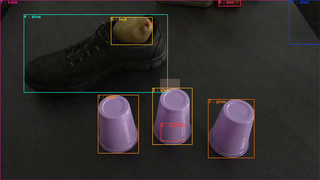
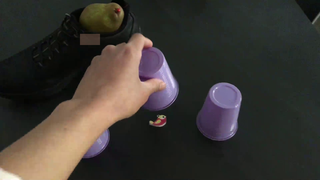
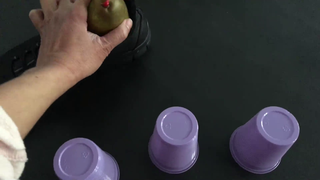
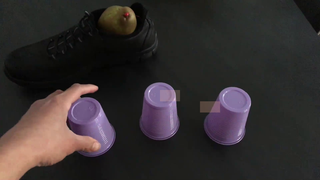
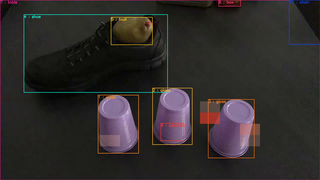
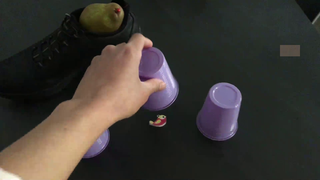
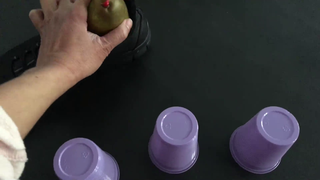
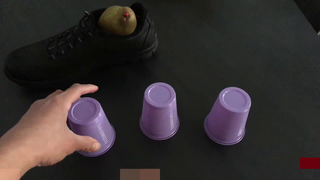
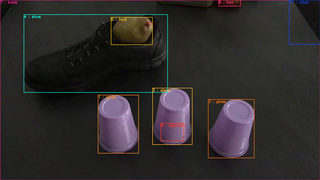
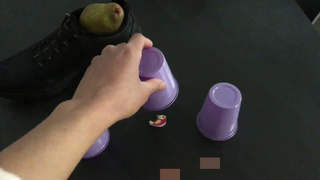
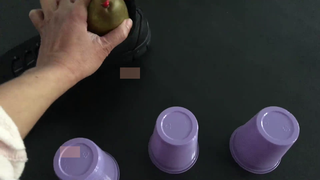
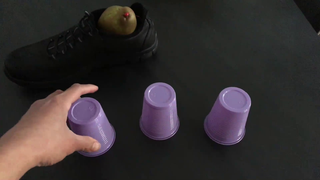
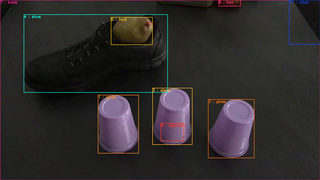
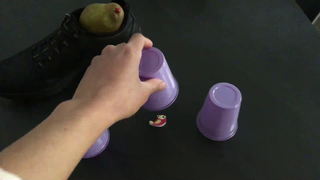
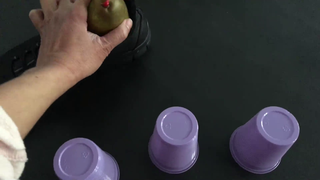
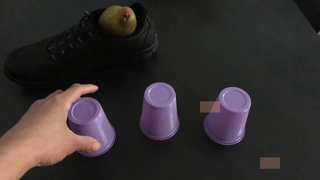
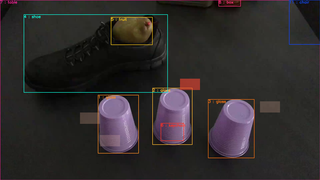
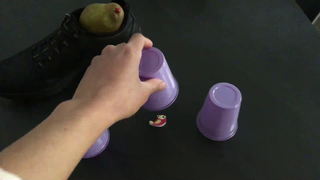
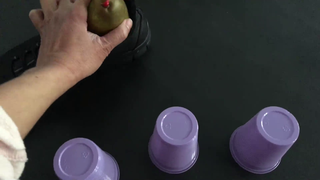
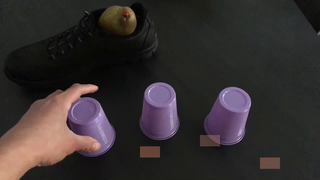
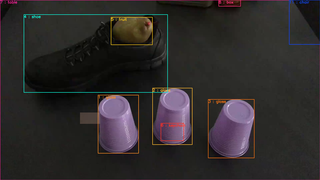
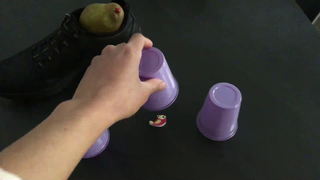
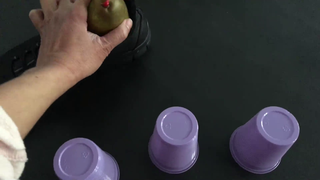
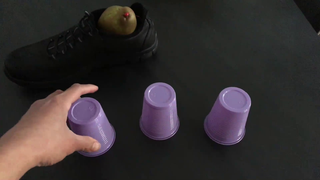
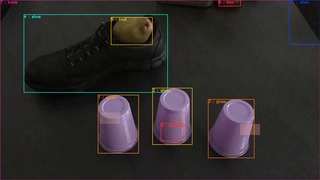
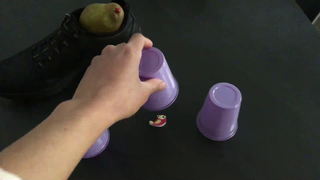
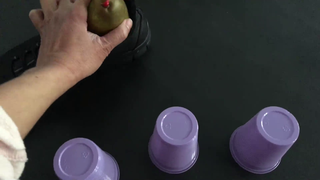
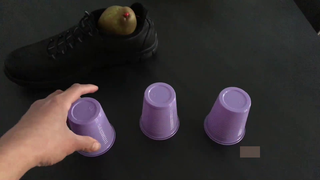
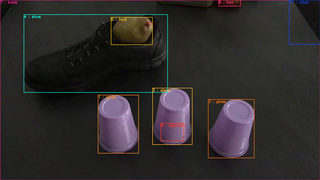
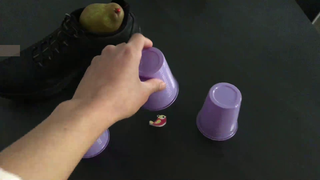
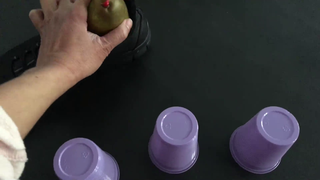
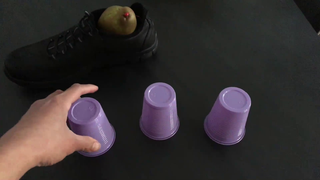
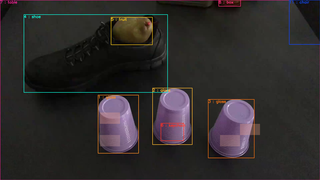
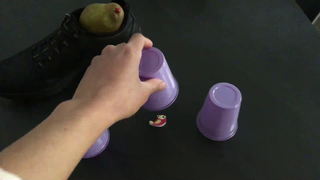
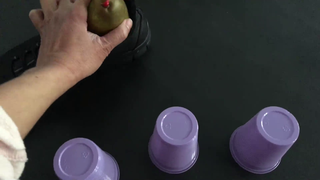
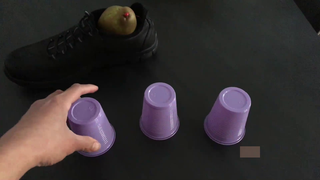
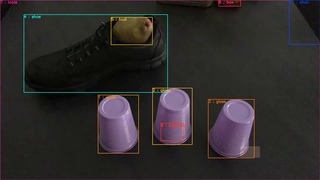
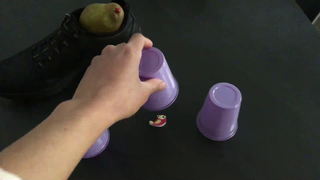
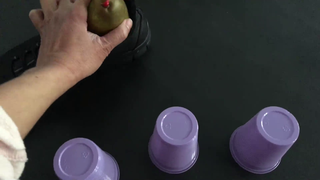
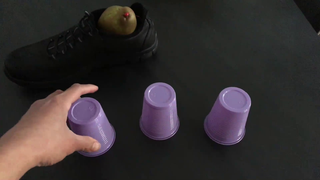
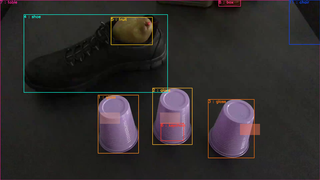
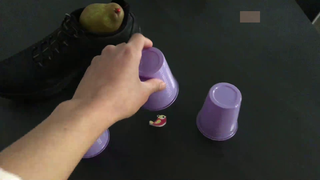
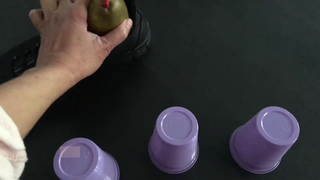
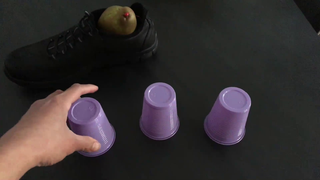
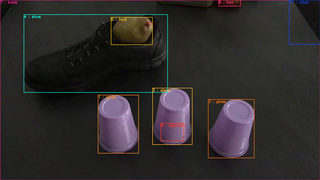
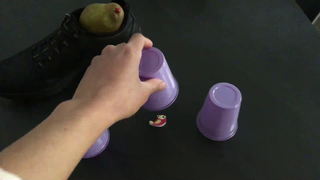
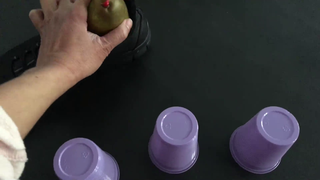
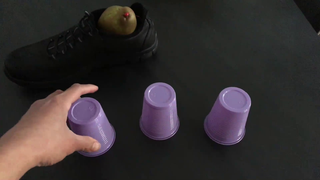

In [185]:
# titles = [f"Layer {i} Frame {j}" for i in range(32) for j in range(4)]
titles = [f"Layer {i} Frame {j}" for i in layers for j in range(4)]
mediapy.show_images(images, width=320, height=180, columns=4, downsample=True, titles=titles)

We can additionally overlay our bounding box annotations. For simplicity, first we'll aggregate our attention over layers and heads by taking the maximum.

In [149]:
# First make attention overlay for first frame
frame_num = 0
# overlaid_attn = overlay_attention(raw_frames[frame_num], attn_maps[:,frame_num].reshape(-1, 16, 16).max(axis=0), normalize=True, max_attn=max_attn, alpha=0.5)

COLORS = get_colors(num_colors=100)
show_all_tracks = True  # @param {type: "boolean"}

tracks = example_data['object_tracking']
box_frames = paint_boxes(frames, tracks)
annotated_frames = box_frames[clamped_frames]

mediapy.show_video(annotated_frames, width=720, fps=1)
# del frames


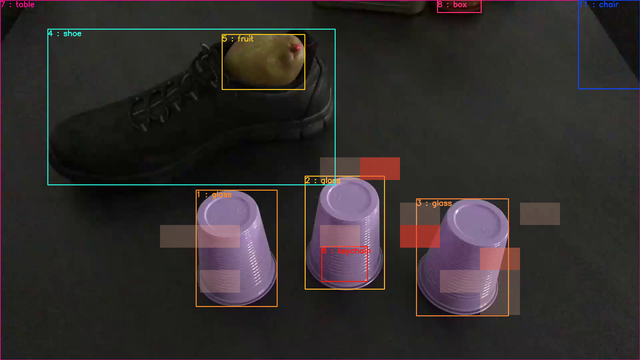
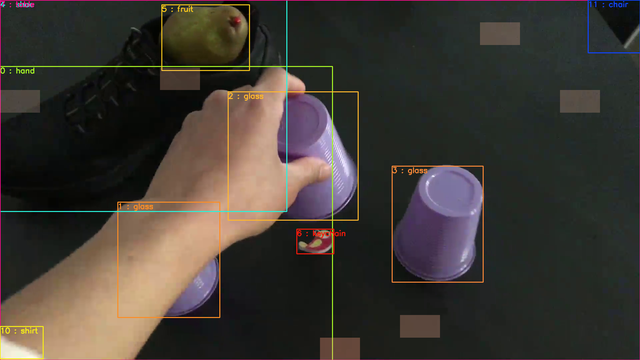
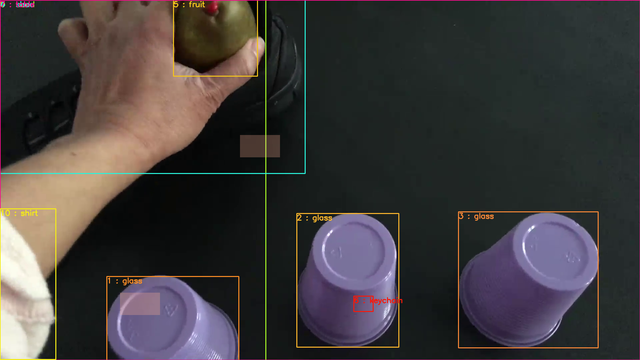
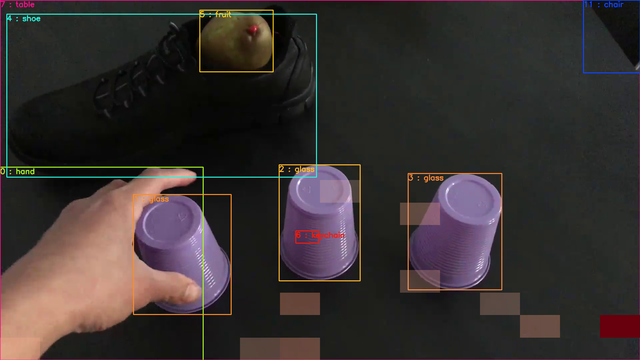

In [186]:
max_attn_maps = attn_maps.transpose(1, 0, 2, 3, 4).reshape(4, -1, 16, 16).max(axis=1)
box_overlays = []
for i, frame in enumerate(annotated_frames):
    box_overlays.append(overlay_attention(frame, max_attn_maps[i], cmap='Reds', normalize=True, max_attn=max_attn, alpha=1, scale_mode="threshold"))
mediapy.show_images(box_overlays, width=640, columns=2, downsample=True, titles=[f"Frame {j}" for j in range(4)])

As expected, the bounding boxes overlap with the attention maps significantly, which is good. Finally we can plot this as a gif so we can look at each individual layer.

In [201]:
from PIL import Image, ImageDraw, ImageFont
from typing import Optional, List

def create_attention_gif(
    attns: np.ndarray,
    images: List[np.ndarray],
    alpha: float = 0.5,
    linger_blocks: List[int] = [],
    linger_duration: int = 3
) -> List[np.ndarray]:
  """Creates a list of frames for a GIF visualizing attention maps.

  For each model layer (block), it concatenates the attention overlays
  for all image frames horizontally. Each element in the returned list
  is a NumPy array representing a frame for the GIF, corresponding to a model block.

  Args:
      attns: A numpy array of attention maps with shape
        (num_blocks, num_frames, height, width).
      images: A list or numpy array of images corresponding to the frames.
        Shape: (num_frames, img_h, img_w, channels). Each image should be
        a NumPy array.
      alpha: Alpha value for blending the attention map on the image.
      linger_blocks: A list of block indices (int) on which to linger.
        Frames for these blocks will be duplicated `linger_duration` times.
      linger_duration: The number of times to duplicate frames for blocks
        specified in `linger_blocks`.

  Returns:
      A list of NumPy arrays, where each array is a frame for the GIF.
  """
  if not isinstance(attns, np.ndarray):
    raise TypeError("Input 'attns' must be a NumPy array.")

  if attns.ndim != 4:
    raise ValueError("Input 'attns' must have 4 dimensions (num_blocks, num_frames, height, width).")

  num_blocks, num_frames, _, _ = attns.shape

  if len(images) != num_frames:
    raise ValueError(f"Number of images ({len(images)}) must match num_frames in attns ({num_frames}).")

  linger_blocks = set(linger_blocks)

  gif_frames = []
  for block_id in range(num_blocks):
    layer_frame_images = []
    for frame_id in range(num_frames):
      attn_grid = attns[block_id, frame_id]
      image = images[frame_id]

      # Assuming overlay_attention returns a NumPy array
      overlayed_image = overlay_attention(
          image, attn_grid, alpha=alpha, normalize=True, max_attn=attns.max(), scale_mode="threshold", threshold=0.2
      )
      layer_frame_images.append(overlayed_image)

    # Concatenate images horizontally for this block
    concatenated_frame = np.concatenate(layer_frame_images, axis=1)

    # Add block number text
    pil_img = Image.fromarray(concatenated_frame)
    draw = ImageDraw.Draw(pil_img)
    font_size = 64
    try:
      # Try to load a nicer font.
      font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except IOError:
      try:
        font = ImageFont.truetype("arial.ttf", font_size)
      except IOError:
        # Fallback to default font.
        font = ImageFont.load_default() # Default font in modern Pillow takes no size
        # Adjust size if possible, though load_default() size arg is deprecated
    text = f"Block {block_id}"

    # Add a black background for the text for better visibility
    try:
      # textbbox is available in recent Pillow versions.
      bbox = draw.textbbox((10, 10), text, font=font)
      # Add some padding
      bbox = (bbox[0] - 5, bbox[1] - 5, bbox[2] + 5, bbox[3] + 5)
      draw.rectangle(bbox, fill="black")
    except (AttributeError, TypeError):
      # Fallback for older versions or if textbbox is not available.
      pass
    draw.text((10, 10), text, fill="white", font=font)
    final_frame = np.array(pil_img)

    if block_id in linger_blocks:
      for _ in range(linger_duration):
        gif_frames.append(final_frame)
    else:
      gif_frames.append(final_frame)

  return gif_frames

In [ ]:
gif = create_attention_gif(attn_maps.max(axis=2), annotated_frames, alpha=1, linger_blocks=[14,17,23], linger_duration=6)
mediapy.show_video(gif, width=1280, fps=3)


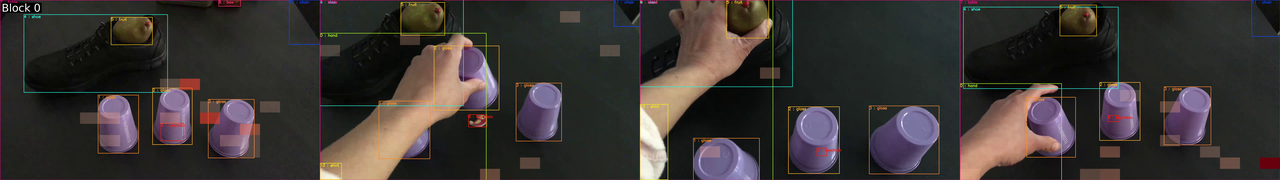

In [202]:
max_gif = create_attention_gif(attn_maps.transpose(0, 2, 1, 3, 4).reshape(-1, 4, 16, 16).max(axis=0, keepdims=True), annotated_frames, alpha=1)
mediapy.show_image(max_gif[0], width=1280)

As a simple extension idea, one can use this to calculate the amount of attention correctly placed inside our bounding boxes, and see if this is a useful predictor of a model's accuracy!